In [76]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import run_LF as LF

%matplotlib inline
plt.style.use(['seaborn-poster','seaborn-ticks'])

In [77]:
%reload_ext autoreload
%autoreload 2

# Defining observational variables from Konno, Ouchi data

In [45]:
Ouchi_info6 = LF.ouchi_data_plt(zval_test = 6.6, plot = False, mean = False)
Konno_info6 = LF.konno_data_plt(zval_test = 6.6, plot = False, mean = False)

Ota_info70 = LF.ota_data_plt(zval_test = 7.0, plot = False, mean = False)
Itoh_info70 = LF.itoh_data_plt(zval_test = 7.0, plot = False, mean = False)
Hu_info70 = LF.hu_data_plt(zval_test = 7.0, plot = False, mean = False)

Konno_info7 = LF.konno_data_plt(zval_test = 7.3, plot = False, mean = False)
Shibuya_info7 = LF.shibuya_data_plt(zval_test = 7.3, plot = False, mean = False)


In [46]:
# z = 6.6 separate

log_L6Ouchi = np.concatenate((Ouchi_info6[0][:3]), axis=None)
ndens6Ouchi = np.concatenate((Ouchi_info6[1][:3]), axis=None)
yerror_l6Ouchi = np.concatenate((Ouchi_info6[2][0][:3]), axis=None)
yerror_u6Ouchi = np.concatenate((Ouchi_info6[2][1][:3]), axis=None)

log_L6Konno = np.concatenate((Konno_info6[0][:3]), axis=None)
ndens6Konno = np.concatenate((Konno_info6[1][:3]), axis=None)
yerror_l6Konno = np.concatenate((Konno_info6[2][0][:3]), axis=None)
yerror_u6Konno = np.concatenate((Konno_info6[2][1][:3]), axis=None)

In [47]:
# z = 6.6 altogether

log_L6 = np.concatenate((Ouchi_info6[0][:3], Konno_info6[0]), axis=None)
ndens6 = np.concatenate((Ouchi_info6[1][:3], Konno_info6[1]), axis=None)
yerror_l6 = np.concatenate((Ouchi_info6[2][0][:3], Konno_info6[2][0]), axis=None)
yerror_u6 = np.concatenate((Ouchi_info6[2][1][:3], Konno_info6[2][1]), axis=None)
print(ndens6)
print(yerror_u6)

[9.77984000e-04 6.00671000e-04 2.75728000e-04 6.39734835e-05
 3.91741877e-05 1.78648757e-05 7.37904230e-06 3.68977599e-06
 2.46036760e-06 6.13762005e-07 5.94292159e-07]
[4.70505000e-04 2.50868000e-04 1.19775000e-04 6.87659622e-05
 1.02568810e-05 3.96242337e-06 2.80687158e-06 2.19866057e-06
 1.94518103e-06 1.41392071e-06 1.36906812e-06]


In [48]:
# z = 7.0 separate

log_L70Itoh = Itoh_info70[0]
ndens70Itoh = Itoh_info70[1]
yerror_l70Itoh = Itoh_info70[2][0]
yerror_u70Itoh = Itoh_info70[2][1]

log_L70Ota = Ota_info70[0]
ndens70Ota = Ota_info70[1]
yerror_l70Ota = Ota_info70[2][0]
yerror_u70Ota = Ota_info70[2][1]

log_L70Hu = Hu_info70[0]
ndens70Hu = Hu_info70[1]
yerror_u70Hu = Hu_info70[2][1]
yerror_l70Hu = Hu_info70[2][0]

In [49]:
# z = 7.0 altogether

log_L70 = np.concatenate(( Ota_info70[0], Itoh_info70[0],Hu_info70[0]), axis=None)
ndens70 = np.concatenate((Ota_info70[1], Itoh_info70[1],Hu_info70[1]), axis=None)
yerror_l70 = np.concatenate((Ota_info70[2][0], Itoh_info70[2][0],Hu_info70[2][0]), axis=None)
yerror_u70 = np.concatenate(( Ota_info70[2][1], Itoh_info70[2][1],Hu_info70[2][1]), axis=None)

In [50]:
# z = 7.3 separate

log_L7Konno = Konno_info7[0]
ndens7Konno = Konno_info7[1]
yerror_l7Konno = Konno_info7[2][0]
yerror_u7Konno = Konno_info7[2][1]

log_L7Shibuya = Shibuya_info7[0]
ndens7Shibuya = Shibuya_info7[1]
yerror_l7Shibuya = Shibuya_info7[2][0]
yerror_u7Shibuya = Shibuya_info7[2][1]



In [51]:
# z = 7.3 altogether

log_L7 = np.concatenate((Shibuya_info7[0], Konno_info7[0]), axis=None)
ndens7 = np.concatenate((Shibuya_info7[1], Konno_info7[1]), axis=None)
yerror_l7 = np.concatenate((Shibuya_info7[2][0], Konno_info7[2][0]), axis=None)
yerror_u7 = np.concatenate((Shibuya_info7[2][1], Konno_info7[2][1]), axis=None)

# Establishing prior, likelihood, & posterior

In [122]:
xHI_min = 0.
xHI_max = 0.95

# xHI_grid = np.linspace(-0.1,1.1)
xHI_grid = np.arange(-0.1, 1.1, 0.01)

def log_prior(theta):
    """
    Returns log(prior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    Returns
    -------
    ln_prior: float
        Natural log of the prior probability function
    """
    xHI = theta
    prob_xHI = np.zeros(len(xHI))
    
    
    prob_xHI[(xHI_min <= xHI) & (xHI <= xHI_max)] = 1. # Log prior (not worrying about normalization)


    ln_prior = np.log(prob_xHI)  # Log of the probability
    return ln_prior

log_prior(theta=xHI_grid)
# plt.scatter(xHI_grid, [np.exp(log_prior(xHI)) for xHI in xHI_grid])
# plt.scatter(xHI_grid, np.exp(log_prior(xHI_grid)))

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0., -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf])

In [108]:
def log_likelihood(theta, x, y, dy_l, dy_u, z, model_err=0.1, log=False):
    """
    Returns log(likelihood) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    x: list, array-like
        x-values of your data
    y: list, array-like
        y-values of your data
    dy: list, array-like
        Uncertainties on the y-values of your data
    
    Returns
    -------
    ln_like: float
        Natural log of the likelihood function
    """
    xHI_mod = theta

    #upperlim indexing
    idx_ul = np.where(dy_l == 0.)[0]
    
    #Nearest neighbor to xHI list
    idx = (np.abs(LF.xHI_list - xHI_mod)).argmin()
    xHI_grid_match = LF.xHI_list[idx]

    # Model LF
    y_model = LF.xHI_model(xHI_grid_match, obs_L = x, zval= z)
    
    # Uncertainty in model LF = 0.1*model
    sigma_Lya_LF = model_err*y_model
    
    if log:
        # Convert linear observations to log
        y_log    = np.log10(y)
        dy_l_log = y_log - np.log10(y-dy_l)
        dy_u_log = np.log10(y+dy_u) - y_log

        y_model_log = np.log10(y_model)
        
        # Model uncertainty now asymmetric
        sigma_Lya_LF_l_log = y_model_log - np.log10(y_model-sigma_Lya_LF)
        sigma_Lya_LF_u_log = np.log10(y_model+sigma_Lya_LF) - y_model_log
        
        # Error bars
        dy_l_total_log = np.sqrt(dy_l_log**2. + sigma_Lya_LF_l_log**2.)
        dy_u_total_log = np.sqrt(dy_u_log**2. + sigma_Lya_LF_u_log**2.)

        A = 1./np.sqrt(2.*np.pi)/(0.5*(dy_l_total_log + dy_u_total_log))

        #Defining split-likelihood
        lnlikelihood   = np.log(A) - 0.5 * ((y_model_log - y_log)/dy_l_total_log)**2. # lower
        lnlikelihood_u = np.log(A) - 0.5 * ((y_model_log - y_log)/dy_u_total_log)**2. # upper
        lnlikelihood[y_model >= y] = lnlikelihood_u[y_model >= y]
    
    else:
        # Error bars
        dy_l_total = np.sqrt(dy_l**2. + sigma_Lya_LF**2.)
        dy_u_total = np.sqrt(dy_u**2. + sigma_Lya_LF**2.)

        A = 1./np.sqrt(2.*np.pi)/(0.5*(dy_l_total + dy_u_total))

        #Defining split-likelihood
        lnlikelihood   = np.log(A) - 0.5 * ((y_model - y)/dy_l_total)**2. # lower
        lnlikelihood_u = np.log(A) - 0.5 * ((y_model - y)/dy_u_total)**2. # upper
        lnlikelihood[y_model >= y] = lnlikelihood_u[y_model >= y]

        # if upper limit exists, replace with this likelihood
        if len(idx_ul) >= 1:
            print('Treating upper limit')
            if y_model[idx_ul] <= y[idx_ul]:

                lnlikelihood[idx_ul] = np.log(1.)

            elif y_model[idx_ul] > y[idx_ul]:

                lnlikelihood[idx_ul] = -(y_model[idx_ul] - y[idx_ul])**2/(2*dy_u[idx_ul]**2)

    ln_like = np.sum(lnlikelihood)
    
    return ln_like
log_likelihood(theta = xHI_grid, x = log_L6, y = ndens6, dy_l = yerror_l6, dy_u = yerror_u6, z = 6.6, model_err=0.1, log=False)

ValueError: operands could not be broadcast together with shapes (40,) (121,) 

In [110]:
def log_posterior(theta, x, y, dy_l, dy_u, z, log=False):
    """
    Returns log(posterior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    x: list, array-like
        x-values of your data
    y: list, array-like
        y-values of your data
    dy: list, array-like
        Uncertainties on the y-values of your data
    
    Returns
    -------
    ln_post: float
        Natural log of the posterior probability function
    """

    ln_post = log_prior(theta) + np.array([log_likelihood(t, x, y, dy_l, dy_u, z, log=log) for t in theta])  # From Bayes Theorem
    return ln_post

log_posterior(theta = xHI_grid, x = log_L6, y = ndens6, dy_l = yerror_l6, dy_u = yerror_u6, z = 6.6, log=False)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


array([        -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf, 113.41417159,
       113.22191795, 113.22191795, 113.36662644, 113.36662644,
       113.36662644, 113.4353442 , 113.4353442 , 113.17468032,
       113.17468032, 112.94796943, 112.94796943, 112.94796943,
       112.56694213, 112.56694213, 112.56694213, 112.31271744,
       112.31271744, 112.31271744, 112.31271744, 111.25360893,
       111.25360893, 111.25360893, 110.48270334, 110.48270334,
       110.48270334, 110.48270334, 109.04028438, 109.04028438,
       109.04028438, 107.55469999, 107.55469999, 107.55469999,
       107.55469999, 106.07594289, 106.07594289, 106.07594289,
       103.71997374, 103.71997374, 103.71997374, 101.86328201,
       101.86328201, 101.86328201,  99.70303925,  99.70303925,
        99.70303925,  99.70303925,  96.68700677,  96.68700677,
        96.68700677,  94.54807856,  94.54807856,  94.54

In [10]:
# z = 6.6
log_post66 = log_posterior(theta = xHI_grid, x = log_L6, y = ndens6, dy_l = yerror_l6, dy_u = yerror_u6, z = 6.6)
log_post66Ouchi = log_posterior(theta = xHI_grid, x = log_L6Ouchi, y = ndens6Ouchi, dy_l = yerror_l6Ouchi, dy_u = yerror_u6Ouchi, z = 6.6)
log_post66Konno = log_posterior(theta = xHI_grid, x = log_L6Konno, y = ndens6Konno, dy_l = yerror_l6Konno, dy_u = yerror_u6Konno, z = 6.6)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/Users/alexamia/Desktop/REU2020/SAO-REU2020/CODE/run_LF.py:580: RuntimeWarning: divide by zero encountered in log10
  pL_interp      = interpolate.interp1d(np.log10(lum_lya[:,mm].value), np.log10(norm_pLya[:,mm]), fill_value=-np.inf, bounds_error=False)
/Users/alexamia/Desktop/REU2020/SAO-REU2020/CODE/run_LF.py:581: RuntimeWarning: divide by zero encountered in log10
  new_pLya_Muv   = 10**pL_interp(np.log10(lum_grid))


In [49]:
# z = 7.0
log_post70 = log_posterior(theta = xHI_grid, x = log_L70, y = ndens70, dy_l = yerror_l70, dy_u = yerror_u70, z = 7.0)
log_post70Itoh = log_posterior(theta = xHI_grid, x = log_L70Itoh, y = ndens70Itoh, dy_l = yerror_l70Itoh, dy_u = yerror_u70Itoh, z = 7.0)
log_post70Ota = log_posterior(theta = xHI_grid, x = log_L70Ota, y = ndens70Ota, dy_l = yerror_l70Ota, dy_u = yerror_u70Ota, z = 7.0)
log_post70Hu = log_posterior(theta = xHI_grid, x = log_L70Hu, y = ndens70Hu, dy_l = yerror_l70Hu, dy_u = yerror_u70Hu, z = 7.0)


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/Users/alexamia/Desktop/REU2020/SAO-REU2020/CODE/run_LF.py:580: RuntimeWarning: divide by zero encountered in log10
  pL_interp      = interpolate.interp1d(np.log10(lum_lya[:,mm].value), np.log10(norm_pLya[:,mm]), fill_value=-np.inf, bounds_error=False)
/Users/alexamia/Desktop/REU2020/SAO-REU2020/CODE/run_LF.py:581: RuntimeWarning: divide by zero encountered in log10
  new_pLya_Muv   = 10**pL_interp(np.log10(lum_grid))


In [61]:
# z = 7.3
log_post73 = log_posterior(theta = xHI_grid, x = log_L7, y = ndens7, dy_l = yerror_l7, dy_u = yerror_u7, z = 7.3)
log_post73Konno = log_posterior(theta = xHI_grid, x = log_L7Konno, y = ndens7Konno, dy_l = yerror_l7Konno, dy_u = yerror_u7Konno, z = 7.3)
log_post73Shibuya = log_posterior(theta = xHI_grid, x = log_L7Shibuya, y = ndens7Shibuya, dy_l = yerror_l7Shibuya, dy_u = yerror_u7Shibuya, z = 7.3)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/Users/alexamia/Desktop/REU2020/SAO-REU2020/CODE/run_LF.py:580: RuntimeWarning: divide by zero encountered in log10
  pL_interp      = interpolate.interp1d(np.log10(lum_lya[:,mm].value), np.log10(norm_pLya[:,mm]), fill_value=-np.inf, bounds_error=False)
/Users/alexamia/Desktop/REU2020/SAO-REU2020/CODE/run_LF.py:581: RuntimeWarning: divide by zero encountered in log10
  new_pLya_Muv   = 10**pL_interp(np.log10(lum_grid))


# Defining function to find xHI for given redshift posterior

In [147]:
def finding_xHI(xHI_grid, z, post, plot = False):
    
    linear_post = np.exp(post)
    integral_post = np.trapz(linear_post, xHI_grid)
    normalized_post = linear_post / integral_post
    
    CDF = np.cumsum(normalized_post*np.gradient(xHI_grid))
    CDF_norm = CDF / CDF.max()

    # 68% Confidence Interval lower, median, upper limit
    CI16 = np.interp(0.16, CDF_norm, xHI_grid)
    CI50 = np.interp(0.5, CDF_norm, xHI_grid)
    CI84 = np.interp(0.84, CDF_norm, xHI_grid)
    print("0.16 CI lower limit:  %s" % CI16)
    print("0.50 CI median limit:  %s" % CI50)
    print("0.84 CI upper limit:  %s" % CI84)

    # 95% Confidence Interval lower, upper limit
    CI025 = np.interp(0.025, CDF_norm, xHI_grid)
    CI975 = np.interp(0.975, CDF_norm, xHI_grid)
    print("0.025 CI lower limit:  %s" % CI025)
    print("0.975 CI upper limit:  %s" % CI975)
    
    
    
    if plot == True:
        plt.plot(xHI_grid, normalized_post, lw=5)
        # 68% CI lower, median, upper limit
        plt.axvline(CI16, color = 'black', lw = 0.9, ls = '--')
        plt.axvline(CI50, color = 'black', lw = 0.9,ls = '--')
        plt.axvline(CI84, color = 'black', lw = 0.9,ls = '--')

        # 95% CI lower, upper limit
        plt.axvline(CI025, color = 'black', lw = 0.9,ls = '-')
        plt.axvline(CI975, color = 'black', lw = 0.9,ls = '-')
        title = mlines.Line2D([], [],marker=' ',linestyle=' ',label='z = %.1f'%z)
        line1 = mlines.Line2D([], [], color='black', ls='--', label='68% Confidence Interval')
        line2 = mlines.Line2D([], [], color='black', ls='-', label='95% Confidence Interval')
        if z == 6.6:
            line3 = mlines.Line2D([], [], color='#1f77b4', ls='-', label='Total Data', lw=5)
            line4 = mlines.Line2D([], [], color='#2ca02c', ls='-', label='Ouchi+10 Data', alpha = 0.6)
            line5 = mlines.Line2D([], [], color='#ff7f0e', ls='-', label='Konno+18 Data', alpha = 0.6)
            line6LD = mlines.Line2D([], [], color='#1f77b4', ls='-', label='Total Data (Konno+18 Only)', lw=5)

#             plt.legend(handles=[title,line1,line2, line3, line4, line5], loc='upper right', frameon=False, handletextpad=0.5, handlelength=1.5)
            plt.legend(handles=[title,line1,line2, line6LD], loc='upper right', frameon=False, handletextpad=0.5, handlelength=1.5)

        if z == 7.0:
            line3 = mlines.Line2D([], [], color='#1f77b4', ls='-', label='Total Data', lw=5)
            line4 = mlines.Line2D([], [], color='#2ca02c', ls='-', label='Itoh+18 Data', alpha = 0.6)
            line5 = mlines.Line2D([], [], color='#ff7f0e', ls='-', label='Ota+17 Data', alpha = 0.6)
            line6 = mlines.Line2D([], [], color='#e377c2', ls='-', label='Hu+19 Data', alpha = 0.6)
            plt.legend(handles=[title,line1,line2, line3, line4, line5, line6], loc='upper right', frameon=False, handletextpad=0.5, handlelength=1.5)            
        if z == 7.3:
            line3 = mlines.Line2D([], [], color='#1f77b4', ls='-', label='Total Data', lw=5)
            line4 = mlines.Line2D([], [], color='#2ca02c', ls='-', label='Konno+14 Data', alpha = 0.6)
            line5 = mlines.Line2D([], [], color='#ff7f0e', ls='-', label='Shibuya+12 Data', alpha = 0.6)
            line6LD = mlines.Line2D([], [], color='#1f77b4', ls='-', label='Total Data (Konno+14 Only)', lw=5)

#             plt.legend(handles=[title,line1,line2, line3, line4, line5], loc='upper left', frameon=False, handletextpad=0.5, handlelength=1.5)

            plt.legend(handles=[title,line1,line2, line6LD], loc='upper left', frameon=False, handletextpad=0.5, handlelength=1.5)
    elif plot == False:
        plt.plot(xHI_grid, normalized_post, alpha = 0.6)
    plt.xlim(0,1)
    plt.xlabel('Neutral Fraction $\overline{x}_\mathrm{HI}$')
    plt.ylabel('Normalized Posterior')
    return

## z = 6.6 posterior

0.16 CI lower limit:  0.02548555872964666
0.50 CI median limit:  0.07573279795708673
0.84 CI upper limit:  0.15212045057189752
0.025 CI lower limit:  0.003558921388798056
0.975 CI upper limit:  0.2220847951907171
0.16 CI lower limit:  0.05167499430172668
0.50 CI median limit:  0.14280417503477968
0.84 CI upper limit:  0.23095142557916626
0.025 CI lower limit:  0.008704690108977757
0.975 CI upper limit:  0.3165327164128331
0.16 CI lower limit:  0.028867354608196824
0.50 CI median limit:  0.09538832379529902
0.84 CI upper limit:  0.19638490063308478
0.025 CI lower limit:  0.004387481991696331
0.975 CI upper limit:  0.3286104891676325


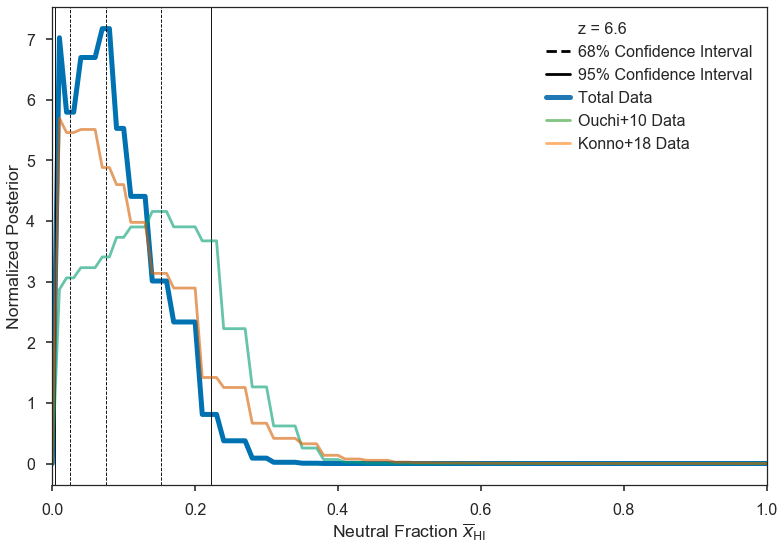

In [99]:
# z = 6.6 altogether

# plt.figure(figsize=(6.,4.), dpi=150)
finding_xHI(xHI_grid, z = 6.6, post = log_post66, plot = True)
finding_xHI(xHI_grid, z = 6.6, post = log_post66Ouchi, plot = False)
finding_xHI(xHI_grid, z = 6.6, post = log_post66Konno, plot = False)
# plt.savefig('xHIminimize66.pdf', bbox_inches='tight')
# plt.show()

0.16 CI lower limit:  0.028867354608196824
0.50 CI median limit:  0.09538832379529902
0.84 CI upper limit:  0.19638490063308478
0.025 CI lower limit:  0.004387481991696331
0.975 CI upper limit:  0.3286104891676325


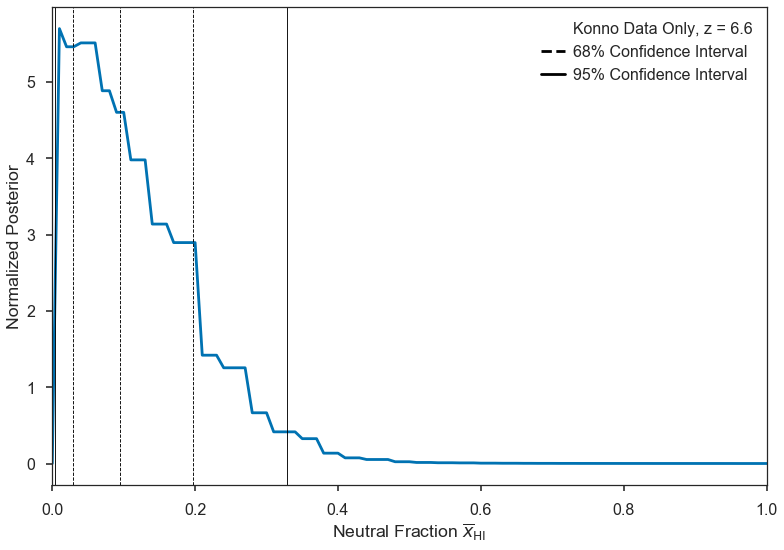

In [34]:
# z = 6.6 separate

# plt.figure(figsize=(6.,4.), dpi=150)
# finding_xHI(xHI_grid, z = 6.6, post = log_post66, plot = True)
# plt.savefig('xHIminimize66Konno.pdf', bbox_inches='tight')
# plt.show()

# plt.figure(figsize=(6.,4.), dpi=150)
# finding_xHI(xHI_grid, z = 6.6, post = log_post66, plot = True)
# plt.savefig('xHIminimize66Ouchi.pdf', bbox_inches='tight')
# plt.show()

## z = 7.0 posterior

0.16 CI lower limit:  0.23726019338010249
0.50 CI median limit:  0.2817203535320667
0.84 CI upper limit:  0.33052764269003687
0.025 CI lower limit:  0.18619391782668662
0.975 CI upper limit:  0.36717485796096144
0.16 CI lower limit:  0.10691342986138166
0.50 CI median limit:  0.2091784534990756
0.84 CI upper limit:  0.33074928167343026
0.025 CI lower limit:  0.03217336206874264
0.975 CI upper limit:  0.4925165856714525
0.16 CI lower limit:  0.18932968661125205
0.50 CI median limit:  0.2781332873503328
0.84 CI upper limit:  0.3600522925157092
0.025 CI lower limit:  0.10749761964589871
0.975 CI upper limit:  0.43989827959530164
0.16 CI lower limit:  0.24148060972123506
0.50 CI median limit:  0.30429714363938865
0.84 CI upper limit:  0.3597394523843128
0.025 CI lower limit:  0.17890067712670824
0.975 CI upper limit:  0.4144442478296017


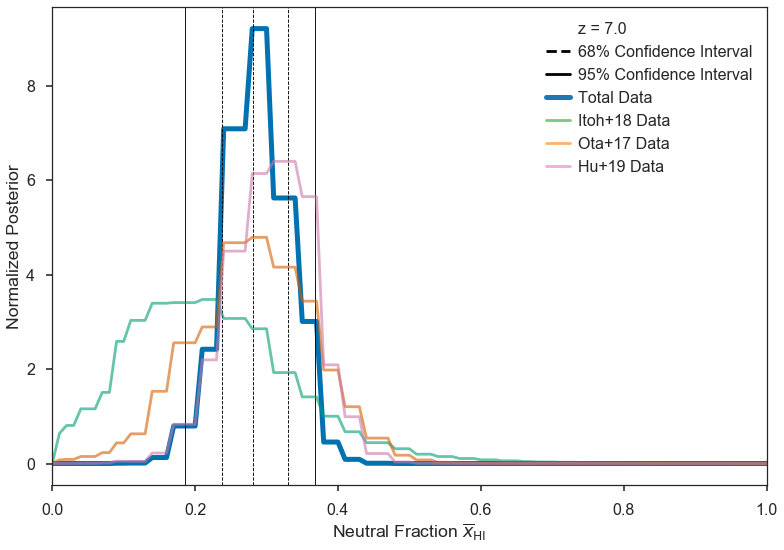

In [92]:
# z = 7.0 altogether

plt.figure(figsize=(6.,4.), dpi = 150.)
finding_xHI(xHI_grid, z = 7.0, post = log_post70, plot = True)
finding_xHI(xHI_grid, z = 7.0, post = log_post70Itoh, plot = False)
finding_xHI(xHI_grid, z = 7.0, post = log_post70Ota, plot = False)
finding_xHI(xHI_grid, z = 7.0, post = log_post70Hu, plot = False)
# plt.savefig('xHIminimize70.pdf', bbox_inches='tight')
# plt.show()

0.16 CI lower limit:  0.24148060972123506
0.50 CI median limit:  0.30429714363938865
0.84 CI upper limit:  0.3597394523843128
0.025 CI lower limit:  0.17890067712670824
0.975 CI upper limit:  0.4144442478296017


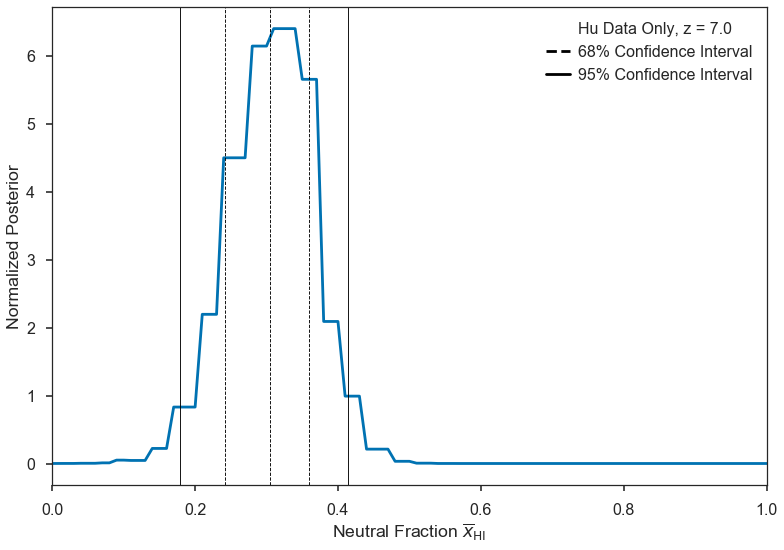

In [62]:
# z = 7.0 separate

# plt.figure(figsize=(6.,4.), dpi = 150.)
# finding_xHI(xHI_grid, z = 7.0, post = log_post70, plot = True)
# plt.savefig('xHIminimize70Ota.pdf', bbox_inches='tight')
# plt.show()

# plt.figure(figsize=(6.,4.), dpi = 150.)
# finding_xHI(xHI_grid, z = 7.0, post = log_post70, plot = True)
# plt.savefig('xHIminimize70Itoh.pdf', bbox_inches='tight')
# plt.show()

# plt.figure(figsize=(6.,4.), dpi = 150.)
# finding_xHI(xHI_grid, z = 7.0, post = log_post70, plot = True)
# plt.savefig('xHIminimize70Hu.pdf', bbox_inches='tight')
# plt.show()

## z = 7.3 posterior

0.16 CI lower limit:  0.7614815023169377
0.50 CI median limit:  0.825574212320615
0.84 CI upper limit:  0.8904911006846071
0.025 CI lower limit:  0.7027539683766817
0.975 CI upper limit:  0.9375396444140767
0.16 CI lower limit:  0.5811253976539182
0.50 CI median limit:  0.6939675752817861
0.84 CI upper limit:  0.8000673722314026
0.025 CI lower limit:  0.4787136626532442
0.975 CI upper limit:  0.8946164994245768
0.16 CI lower limit:  0.805476326972222
0.50 CI median limit:  0.8774093563831632
0.84 CI upper limit:  0.9277495660060766
0.025 CI lower limit:  0.7342167913303563
0.975 CI upper limit:  0.9465246719324703


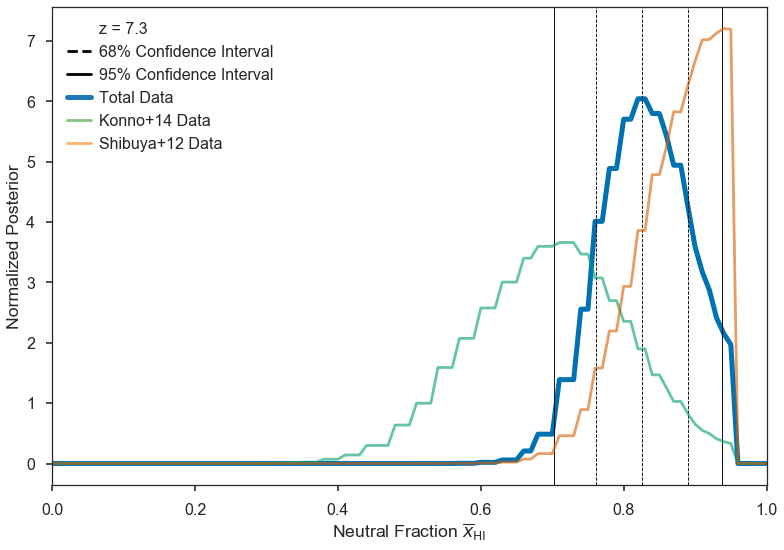

In [93]:
# z = 7.3 altogether

# plt.figure(figsize=(6.,4.), dpi=150)
finding_xHI(xHI_grid, z = 7.3, post = log_post73, plot = True)
finding_xHI(xHI_grid, z = 7.3, post = log_post73Konno, plot = False)
finding_xHI(xHI_grid, z = 7.3, post = log_post73Shibuya, plot = False)

plt.savefig('xHIminimize73.pdf', bbox_inches='tight')
plt.show()

0.16 CI lower limit:  0.805476326972222
0.50 CI median limit:  0.8774093563831632
0.84 CI upper limit:  0.9277495660060766
0.025 CI lower limit:  0.7342167913303563
0.975 CI upper limit:  0.9465246719324703


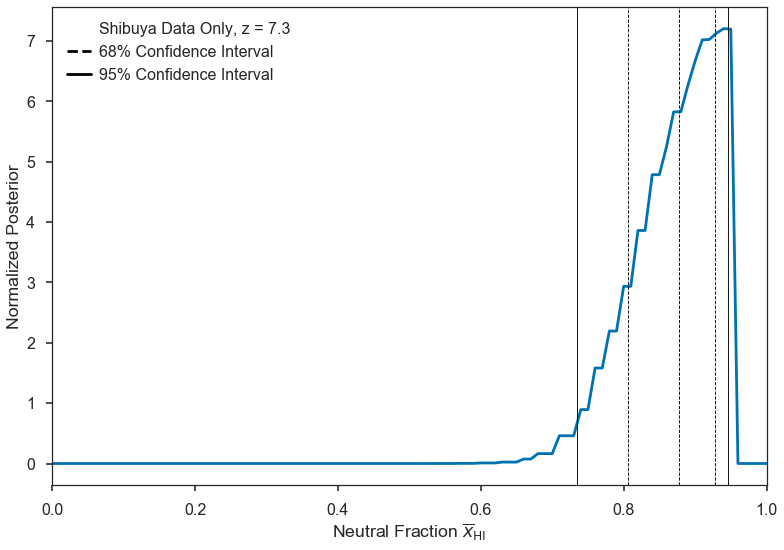

In [83]:
# z = 7.3 separate

# plt.figure(figsize=(6.,4.), dpi=150)
# finding_xHI(xHI_grid, z = 7.3, post = log_post73, plot = True)
# plt.savefig('xHIminimize73Konno.pdf', bbox_inches='tight')
# plt.show()

# plt.figure(figsize=(6.,4.), dpi=150)
# finding_xHI(xHI_grid, z = 7.3, post = log_post73, plot = True)
# plt.savefig('xHIminimize73Shibuya.pdf', bbox_inches='tight')
# plt.show()

# Luminosity Density 

## Observational Data

In [92]:
LD_Konno_info5 = LF.LD_konno_data_plt(zval_test=5.7, mean = False)

LD_Konno_info6 = LF.LD_konno_data_plt(zval_test=6.6, mean = False)

LD_Hu_info7 = LF.LD_hu_data_plt(zval_test=7.0, mean = False)

LD_Ota_info7 = LF.LD_ota_data_plt(zval_test=7.0, mean = False)

LD_Itoh_info7 = LF.LD_itoh_data_plt(zval_test=7.0, mean = False)

LD_Konno_info73 = LF.LD_konno_data_plt(zval_test=7.3, mean = False)


In [93]:
LD_Konno5 = np.concatenate((LD_Konno_info5[0]), axis=None)
LD_Konno5_yerror_l = np.concatenate((LD_Konno_info5[1][0]), axis=None)
LD_Konno5_yerror_u = np.concatenate((LD_Konno_info5[1][1]), axis=None)

#***********************************************************************

LD_Konno6 = np.concatenate((LD_Konno_info6[0]), axis=None)
LD_Konno6_yerror_l = np.concatenate((LD_Konno_info6[1][0]), axis=None)
LD_Konno6_yerror_u = np.concatenate((LD_Konno_info6[1][1]), axis=None)

#***********************************************************************

LD_Hu7 = np.concatenate((LD_Hu_info7[0]), axis=None)
LD_Hu7_yerror_l = np.concatenate((LD_Hu_info7[1][0]), axis=None)
LD_Hu7_yerror_u = np.concatenate((LD_Hu_info7[1][1]), axis=None)

LD_Ota7 = np.concatenate((LD_Ota_info7[0]), axis=None)
LD_Ota7_yerror_l = np.concatenate((LD_Ota_info7[1][0]), axis=None)
LD_Ota7_yerror_u = np.concatenate((LD_Ota_info7[1][1]), axis=None)

LD_Itoh7 = np.concatenate((LD_Itoh_info7[0]), axis=None)
LD_Itoh7_yerror_l = np.concatenate((LD_Itoh_info7[1][0]), axis=None)
LD_Itoh7_yerror_u = np.concatenate((LD_Itoh_info7[1][1]), axis=None)

#LD z = 7.0 altogether
LD_z7 = np.concatenate((LD_Hu_info7[0],LD_Ota_info7[0],LD_Itoh_info7[0]), axis=None)
LD_z7_yerror_l = np.concatenate((LD_Hu_info7[1][0],LD_Ota_info7[1][0],LD_Itoh_info7[1][0]), axis=None)
LD_z7_yerror_u = np.concatenate((LD_Hu_info7[1][1],LD_Ota_info7[1][1],LD_Itoh_info7[1][1]), axis=None)

#***********************************************************************

LD_Konno73 = np.concatenate((LD_Konno_info73[0]), axis=None)
LD_Konno73_yerror_l = np.concatenate((LD_Konno_info73[1][0]), axis=None)
LD_Konno73_yerror_u = np.concatenate((LD_Konno_info73[1][1]), axis=None)

## Establishing likelihood, posterior

In [123]:
def LDlog_likelihood(theta, y, dy_l, dy_u, z, model_err=0.1, log=False):
    """
    Returns log(likelihood) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    y: list, array-like
        y-values of your data
    dy: list, array-like
        Uncertainties on the y-values of your data
    z: float, redshift
    
    Returns
    -------
    ln_like: float
        Natural log of the likelihood function
    """
    xHI_mod = theta

    #upperlim indexing
    idx_ul = np.where(dy_l == 0.)[0]
    
    #Nearest neighbor to xHI list
    idx = (np.abs(LF.xHI_list - xHI_mod)).argmin()
    xHI_grid_match = LF.xHI_list[idx]

    # Model LD
#     y_model = LF.xHI_model(xHI_grid_match, obs_L = x, zval= z)
    y_model = LF.LD_info(xHI_grid_match,zval_test=z)
    
    # Uncertainty in model LF = 0.1*model
    sigma_Lya_LF = model_err*y_model
    
    if log:
        # Convert linear observations to log
        y_log    = np.log10(y)
        dy_l_log = y_log - np.log10(y-dy_l)
        dy_u_log = np.log10(y+dy_u) - y_log

        y_model_log = np.log10(y_model)
        
        # Model uncertainty now asymmetric
        sigma_Lya_LF_l_log = y_model_log - np.log10(y_model-sigma_Lya_LF)
        sigma_Lya_LF_u_log = np.log10(y_model+sigma_Lya_LF) - y_model_log
        
        # Error bars
        dy_l_total_log = np.sqrt(dy_l_log**2. + sigma_Lya_LF_l_log**2.)
        dy_u_total_log = np.sqrt(dy_u_log**2. + sigma_Lya_LF_u_log**2.)

        A = 1./np.sqrt(2.*np.pi)/(0.5*(dy_l_total_log + dy_u_total_log))

        #Defining split-likelihood
        lnlikelihood   = np.log(A) - 0.5 * ((y_model_log - y_log)/dy_l_total_log)**2. # lower
        lnlikelihood_u = np.log(A) - 0.5 * ((y_model_log - y_log)/dy_u_total_log)**2. # upper
        lnlikelihood[y_model >= y] = lnlikelihood_u[y_model >= y]
    
    else:
        # Error bars
        dy_l_total = np.sqrt(dy_l**2. + sigma_Lya_LF**2.)
        dy_u_total = np.sqrt(dy_u**2. + sigma_Lya_LF**2.)

        A = 1./np.sqrt(2.*np.pi)/(0.5*(dy_l_total + dy_u_total))

        #Defining split-likelihood
        lnlikelihood   = np.log(A) - 0.5 * ((y_model - y)/dy_l_total)**2. # lower
        lnlikelihood_u = np.log(A) - 0.5 * ((y_model - y)/dy_u_total)**2. # upper
        lnlikelihood[y_model >= y] = lnlikelihood_u[y_model >= y]

        # if upper limit exists, replace with this likelihood
        if len(idx_ul) >= 1:
            print('Treating upper limit')
            if y_model[idx_ul] <= y[idx_ul]:

                lnlikelihood[idx_ul] = np.log(1.)

            elif y_model[idx_ul] > y[idx_ul]:

                lnlikelihood[idx_ul] = -(y_model[idx_ul] - y[idx_ul])**2/(2*dy_u[idx_ul]**2)

    ln_like = np.sum(lnlikelihood)
    
    return ln_like


In [125]:
def LDlog_posterior(theta, y, dy_l, dy_u, z, log=False):
    """
    Returns log(posterior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    y: list, array-like
        y-values of your data
    dy: list, array-like
        Uncertainties on the y-values of your data
    z: float, redshift
    
    Returns
    -------
    ln_post: float
        Natural log of the posterior probability function
    """

    ln_post = log_prior(theta) + np.array([LDlog_likelihood(t, y, dy_l, dy_u, z, log=log) for t in theta])  # From Bayes Theorem
    return ln_post


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


array([         -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,  -90.95536203,
        -90.83806081,  -90.83806081,  -90.67927374,  -90.67927374,
        -90.67927374,  -90.50350209,  -90.50350209,  -90.28494927,
        -90.28494927,  -90.14823581,  -90.14823581,  -90.14823581,
        -89.92583766,  -89.92583766,  -89.92583766,  -89.79585243,
        -89.79585243,  -89.79585243,  -89.79585243,  -89.72829831,
        -89.72829831,  -89.72829831,  -89.74486417,  -89.74486417,
        -89.74486417,  -89.74486417,  -89.83702893,  -89.83702893,
        -89.83702893,  -90.0512283 ,  -90.0512283 ,  -90.0512283 ,
        -90.0512283 ,  -90.29428006,  -90.29428006,  -90.29428006,
        -90.7077794 ,  -90.7077794 ,  -90.7077794 ,  -91.10658706,
        -91.10658706,  -91.10658706,  -91.60476597,  -91.60476597,
        -91.60476597,  -91.60476597,  -92.26902565,  -92.26902

### z = 6.6 posterior

In [126]:
# z = 6.6
LDlog_post66 = LDlog_posterior(theta = xHI_grid, z=6.6, y = LD_Konno6, dy_l = LD_Konno6_yerror_l, dy_u = LD_Konno6_yerror_u)


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


0.16 CI lower limit:  0.1083892134751255
0.50 CI median limit:  0.22430776359982876
0.84 CI upper limit:  0.3394644762786876
0.025 CI lower limit:  0.0235284154317745
0.975 CI upper limit:  0.45392791482897993


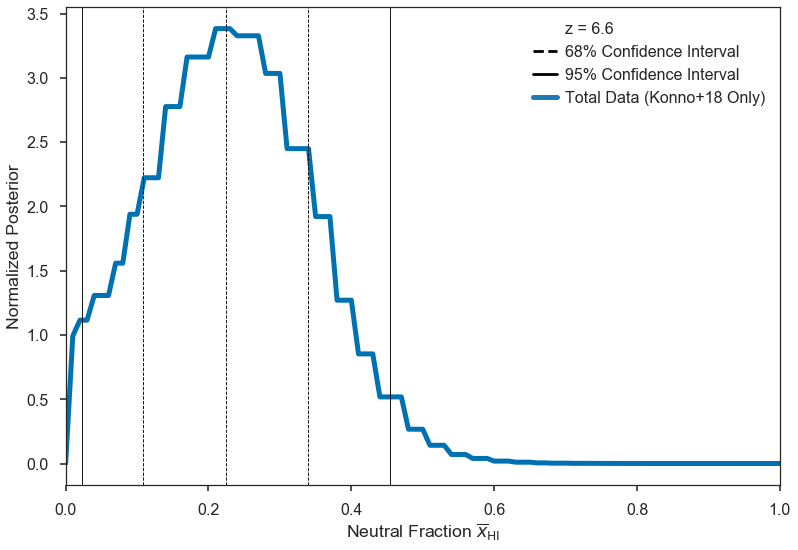

In [149]:
finding_xHI(xHI_grid, z = 6.6, post = LDlog_post66, plot = True)
# plt.savefig('xHIminLD66.pdf', bbox_inches='tight')
# plt.show()

### z = 7.0 posterior

In [133]:
# z = 7.0
LDlog_post70 = LDlog_posterior(theta = xHI_grid,y = LD_z7, dy_l = LD_z7_yerror_l, dy_u = LD_z7_yerror_u, z = 7.0)
LDlog_post70Itoh = LDlog_posterior(theta = xHI_grid, y = LD_Itoh7, dy_l = LD_Itoh7_yerror_l, dy_u = LD_Itoh7_yerror_u, z = 7.0)
LDlog_post70Ota = LDlog_posterior(theta = xHI_grid, y = LD_Ota7, dy_l = LD_Ota7_yerror_l, dy_u = LD_Ota7_yerror_u, z = 7.0)
LDlog_post70Hu = LDlog_posterior(theta = xHI_grid, y = LD_Hu7, dy_l = LD_Hu7_yerror_l, dy_u = LD_Hu7_yerror_u, z = 7.0)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


0.16 CI lower limit:  0.1699024667796587
0.50 CI median limit:  0.25402213478839125
0.84 CI upper limit:  0.32917535092436573
0.025 CI lower limit:  0.083226622072021
0.975 CI upper limit:  0.3952381600422785
0.16 CI lower limit:  0.08644219194102605
0.50 CI median limit:  0.22120401156855019
0.84 CI upper limit:  0.36230795564910406
0.025 CI lower limit:  0.015009302974831024
0.975 CI upper limit:  0.5043500182474087
0.16 CI lower limit:  0.19904543767289481
0.50 CI median limit:  0.4159810563560553
0.84 CI upper limit:  0.6955157598800992
0.025 CI lower limit:  0.04999387830189802
0.975 CI upper limit:  0.8986610828324555
0.16 CI lower limit:  0.13388141488679456
0.50 CI median limit:  0.24385392825921287
0.84 CI upper limit:  0.3401582719818216
0.025 CI lower limit:  0.034802943880753515
0.975 CI upper limit:  0.4273965276391308


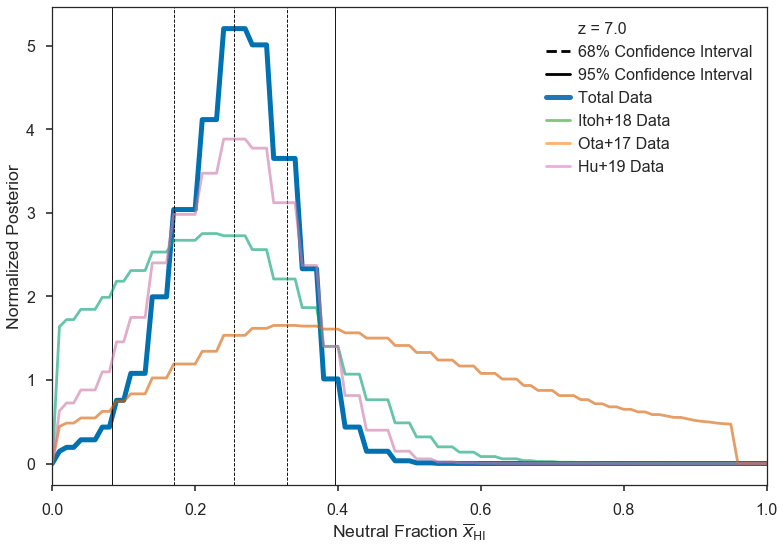

In [150]:
# z = 7.0 altogether

# plt.figure(figsize=(6.,4.), dpi = 150.)
finding_xHI(xHI_grid, z = 7.0, post = LDlog_post70, plot = True)
finding_xHI(xHI_grid, z = 7.0, post = LDlog_post70Itoh, plot = False)
finding_xHI(xHI_grid, z = 7.0, post = LDlog_post70Ota, plot = False)
finding_xHI(xHI_grid, z = 7.0, post = LDlog_post70Hu, plot = False)
# plt.savefig('xHIminLD70.pdf', bbox_inches='tight')
# plt.show()

### z  = 7.3 posterior

In [135]:
# z = 7.3
LDlog_post73 = LDlog_posterior(theta = xHI_grid, z=7.3, y = LD_Konno73, dy_l = LD_Konno73_yerror_l, dy_u = LD_Konno73_yerror_u)


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/Users/alexamia/Desktop/REU2020/SAO-REU2020/CODE/run_LF.py:778: RuntimeWarning: divide by zero encountered in log10
  pL_interp      = interpolate.interp1d(np.log10(lum_lya[:,mm].value), np.log10(norm_pLya[:,mm]), fill_value=-np.inf, bounds_error=False)
/Users/alexamia/Desktop/REU2020/SAO-REU2020/CODE/run_LF.py:779: RuntimeWarning: divide by zero encountered in log10
  new_pLya_Muv   = 10**pL_interp(np.log10(lum_grid))


0.16 CI lower limit:  0.5769348597930756
0.50 CI median limit:  0.6936371995621505
0.84 CI upper limit:  0.806382952473905
0.025 CI lower limit:  0.4704713966500301
0.975 CI upper limit:  0.9057472294521965


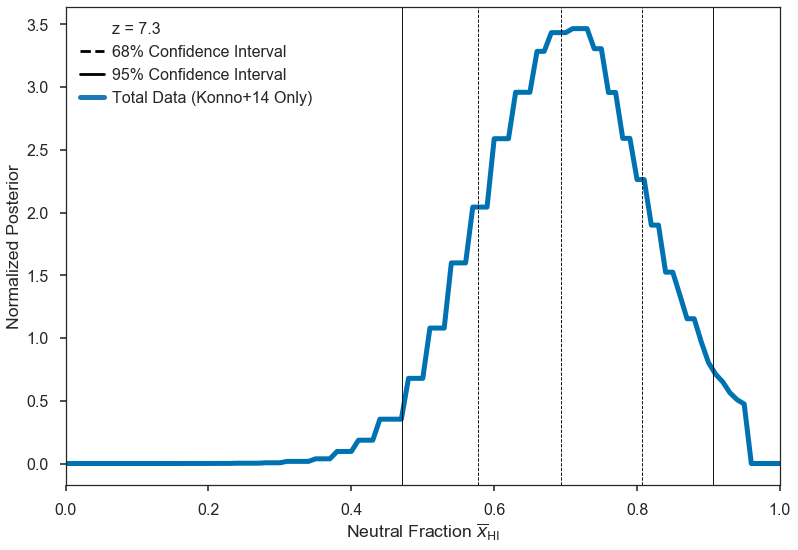

In [152]:
finding_xHI(xHI_grid, z = 7.3, post = LDlog_post73, plot = True)
# plt.savefig('xHIminLD73.pdf', bbox_inches='tight')
# plt.show()

# Test Code

In [155]:
#Test Cell
np.random.seed(0)

y_model = np.ones(10)
y = np.random.rand(10)+0.5
likelihood = (y_model - y)**2.
# likelihood = 1

# likelihood[y_model >= y] = 0
print(likelihood[y_model >= y])

likelihood2 = -(y_model - y)**2.
print(likelihood2[y_model >= y])
likelihood[y_model >= y] = likelihood2[y_model >= y]
print(likelihood)

[0.00582859 0.00389536 0.01358588]
[-0.00582859 -0.00389536 -0.01358588]
[ 0.00238276  0.04630646  0.01056031  0.0020145  -0.00582859  0.02128509
 -0.00389536  0.15348608  0.21498316 -0.01358588]


In [117]:
idx = (np.abs(LF.xHI_list - xHI_mod)).argmin()
xHI_grid_match = LF.xHI_list[idx]

y_model = LF.xHI_model(xHI_grid_match, obs_L = x, zval= z)

(121,)
